In [2]:
import sys
import os

In [ ]:
import os
import cv2
import numpy as np

from PIL import Image
from pathlib import Path
from functools import partial

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms as T

In [4]:
class WoodblockDataset(Dataset):
    def __init__(
        self,
        dataset_dir,
        train,
        subset=-1
    ):
        super().__init__()
        self.dataset_dir = Path(dataset_dir) / ('train' if train else 'subtest')
        self.print_dir = self.dataset_dir / 'print_512'
        self.depth_dir = self.dataset_dir / 'np_depth_512'

        self.print_img_path_list = list(Path(self.print_dir).glob("*.png"))
        self.depth_img_path_list = [Path(os.path.join(self.depth_dir, print_img_path.stem + ".npy")) for print_img_path in self.print_img_path_list]
        
        if subset != -1:
            self.print_img_path_list = self.print_img_path_list[:subset]
            self.depth_img_path_list = self.depth_img_path_list[:subset]

        self.transform = T.Compose([
            T.ToTensor(),
            T.Lambda(lambda t: (t * 2) - 1)
        ])
        
    def __len__(self):
        return len(self.print_img_path_list)

    def preprocess_image(self, image_path):
        """Utility function that load an image an convert to torch."""
        # open image using OpenCV (HxWxC)
        img = Image.open(image_path).convert('L')
        # convert image to torch tensor (CxHxW)
        img_t: torch.Tensor = self.transform(img)
        return img_t

    def preprocess_depth(self, depth_path):
        """Utility function that load an image an convert to torch."""
        # open image using OpenCV (HxWxC)
        img: np.ndarray = np.load(depth_path)
        img = np.asarray(img, dtype=np.float16)
        
        mask = img != img.max()
        mask = np.expand_dims(mask, axis=0)
        t_mask = torch.from_numpy(mask)
        
        t_img = self.transform(img)
        return t_img, t_mask
    
    def __getitem__(self, index):
        print_path = self.print_img_path_list[index]
        depth_path = self.depth_img_path_list[index]

        t_print = self.preprocess_image(print_path)
        t_depth, mask = self.preprocess_depth(depth_path)
        
        # mask = t_depth != torch.max(t_depth)

        return t_depth, t_print, mask

In [7]:
dataset_dir = "/mnt/hmi/thuong/wb_train_val_test_dataset/"
train = False
subset=-1
wb_dataset = WoodblockDataset(dataset_dir, train, subset)

In [8]:
sample = wb_dataset[0]

In [18]:
sample[2].dtype

torch.bool

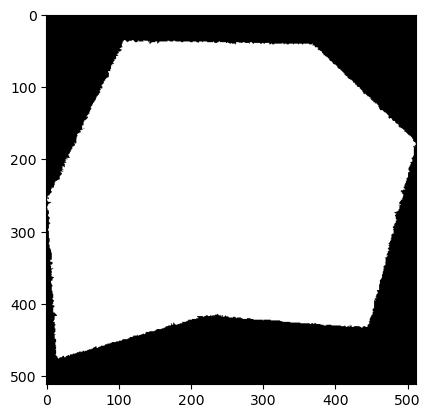

In [15]:
import matplotlib.pyplot as plt
plt.imshow(torch.squeeze(sample[2], 0), cmap='gray')

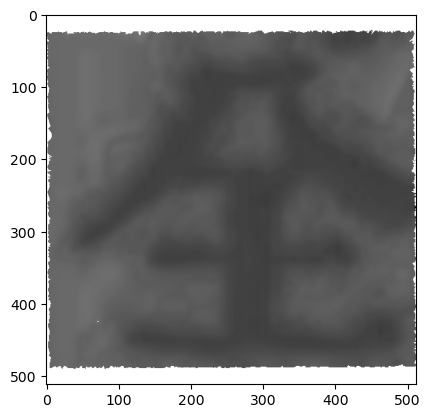

In [9]:
import numpy as np
from matplotlib import pyplot as plt

np_path = "/mnt/hmi/thuong/I2SB/results/vanila_exp/samples_nfe999_clip/01607_mk2_167.npy"
np_img = np.load(np_path)

plt.imshow(np_img, cmap='gray')